# Lecture 6 — Prompting & Prompt Engineering (Theory + Practice)

本 Notebook 覆盖 Lec6 的主要理论要点，并配套一些可运行 / 可扩展的代码示例，整体结构：

1. Prompting 动机：从 pre-train & fine-tune 到 pre-train, prompt, predict  
2. Prompting 在 NLP 中：硬提示 (hard prompt)、软提示 (soft prompt)、ICL、CoT  
3. 一个玩具示例：在小型文本分类任务上对比「全量微调」vs「软提示调优」  
4. Prompting 在 CV 中：视觉 prompt、像素级 / embedding 级软 prompt 概念示例  
5. Prompting 在 VLM 中：CLIP 式零样本分类、CoOp / CoCoOp / MaPLe 的思想示例  
6. 小结 & 延伸阅读 / 实验建议

> 为了保证 Notebook 在普通 CPU 环境也能跑，代码部分主要用小模型 + 合成数据做直觉示范，而不是直接调用大规模 LLM / VLM。


In [1]:
import math
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


Using device: cpu


## 1. Prompting 的动机回顾

Lec6 强调了当前深度学习范式的一个重要变化：从 **预训练 + 全量微调**，逐渐过渡到 **预训练 + Prompting**。

### 1.1 传统范式：Pre-train & Fine-tune

- 先在大规模无标注 / 弱标注数据上预训练一个基座模型（BERT、T5、ViT、CLIP 等）。  
- 对每个下游任务：
  - 新建一个 task-specific 头部 (head)，比如分类头；
  - 在下游标注数据上更新所有参数（或大部分参数）。

特点：
- 需要存多份模型副本（每个任务一份）。  
- 训练 / 存储成本随任务数线性增加。  
- 对于大模型（10B+ 参数）甚至不可行（API only, 不开放权重）。

### 1.2 Prompting 范式：Pre-train, Prompt, Predict

核心思想：冻结预训练模型权重，通过改造输入（加入 prompt）去「对齐」预训练任务与下游任务。

- Pre-train：例如「下一个词预测」或「图文对比学习」。  
- Prompt：把下游任务重新包装成类似预训练形式，例如：  
  - 情感分类 → 变成「补全一句话中 sentiment 的描述」。  
  - 图像分类 → 变成「哪个文本描述与这张图像最相似」。  
- Predict：直接用 frozen 模型做前向推理；可选地只更新极少量 prompt 相关参数（soft prompt tuning）。

对大模型的好处：
- 不需要更新/保存全部参数，降低算力和存储压力；  
- 只要有 API，就能通过不同 prompt 复用同一个模型，实现「多任务统一」。


## 2. Prompting 在 NLP 中的理论概念

### 2.1 Pre-train, Prompt, Predict 流程

1. Pre-train：自监督预训练任务，比如：
   - 下一个词预测 (语言模型)：给定 `"Artificial Intelligence is"`，预测下一个词。  
   - Masked LM：随机 mask 一些 token，预测被 mask 的位置。

2. Prompt：把下游任务「改写」成预训练任务的形式，例如情感分析：  
   - 原任务：
     - 输入：`"I love machine learning"`  
     - 输出：`positive` / `negative`  
   - Prompt 后：
     - 输入：`"The sentiment of 'I love machine learning' is [MASK]."`  
     - 输出：预测 `[MASK]` 位置为 `positive`。

3. Predict：冻结预训练模型参数，用构造好的 prompt 直接预测。

### 2.2 Prompt Engineering：硬提示 vs 软提示

- Hard / Discrete Prompt：自然语言字符串，可解释，但敏感且设计困难；  
- Soft / Continuous Prompt：embedding 空间中的连续向量，不可读但可通过梯度学习，更接近参数高效微调。


### 2.3 文本层面的小例子：ICL 和 CoT（仅字符串示例）

下面这个小函数不会真正调用 LLM，只是展示不同 prompt 形态的写法，方便你在有 LLM 的环境里替换成真实调用。


In [2]:
def build_zero_shot_prompt(question: str) -> str:
    return f'Q: {question}\nA:'

def build_few_shot_icl_prompt(examples, question: str) -> str:
    # examples: list of (q, a)
    lines = []
    for q, a in examples:
        lines.append(f'Q: {q}\nA: {a}\n')
    lines.append(f'Q: {question}\nA:')
    return '\n'.join(lines)

def build_cot_prompt(question: str, few_shot_rationales=None) -> str:
    # few_shot_rationales: list of (q, rationale, a)
    lines = []
    if few_shot_rationales:
        for q, rationale, a in few_shot_rationales:
            lines.append(
                f'Q: {q}\nA: Let\'s think step by step. {rationale} So the answer is {a}.\n'
            )
    lines.append(f'Q: {question}\nA: Let\'s think step by step.')
    return '\n'.join(lines)

q = 'If Tom has 3 apples and buys 2 more, how many apples does he have?'
examples = [('2+2= ?', '4'), ('1+3=?', '4')]
cot_examples = [('What is 2+3?', '2+3=5.', '5')]

print('--- Zero-shot prompt ---\n', build_zero_shot_prompt(q))
print('\n--- Few-shot ICL prompt ---\n', build_few_shot_icl_prompt(examples, q))
print('\n--- CoT-style prompt ---\n', build_cot_prompt(q, cot_examples))


--- Zero-shot prompt ---
 Q: If Tom has 3 apples and buys 2 more, how many apples does he have?
A:

--- Few-shot ICL prompt ---
 Q: 2+2= ?
A: 4

Q: 1+3=?
A: 4

Q: If Tom has 3 apples and buys 2 more, how many apples does he have?
A:

--- CoT-style prompt ---
 Q: What is 2+3?
A: Let's think step by step. 2+3=5. So the answer is 5.

Q: If Tom has 3 apples and buys 2 more, how many apples does he have?
A: Let's think step by step.


## 3. 玩具实验：全量微调 vs 软 Prompt Tuning（文本分类）

我们用一个合成的情感分类任务，对比两种方式：

1. Full Fine-tuning：训练一个小的 Text Encoder（Embedding + 平均池化）和分类头，更新所有参数；  
2. Soft Prompt Tuning：用训练好的 Encoder 作为「预训练模型」，冻结其所有参数；在输入序列前添加若干可学习的 prompt 向量，只更新这些 prompt 向量和线性分类头。


### 3.1 构造玩具情感数据集

- 正向词：`good, great, awesome, nice`  
- 负向词：`bad, terrible, awful, worse`  
- 中性词：`movie, film, plot, acting, very, not, so, really`  

规则：若一句话中正向词数 > 负向词数，则 label = 1，否则 0。


In [3]:
vocab = [
    '<pad>', '<unk>',
    'good', 'great', 'awesome', 'nice',
    'bad', 'terrible', 'awful', 'worse',
    'movie', 'film', 'plot', 'acting',
    'very', 'not', 'so', 'really'
]
token_to_id = {tok: i for i, tok in enumerate(vocab)}
id_to_token = {i: tok for tok, i in token_to_id.items()}

positive_words = {'good', 'great', 'awesome', 'nice'}
negative_words = {'bad', 'terrible', 'awful', 'worse'}
neutral_words = {'movie', 'film', 'plot', 'acting', 'very', 'not', 'so', 'really'}

def sample_sentence(min_len=4, max_len=8):
    length = random.randint(min_len, max_len)
    all_words = list(positive_words | negative_words | neutral_words)
    words = [random.choice(all_words) for _ in range(length)]
    pos_count = sum(w in positive_words for w in words)
    neg_count = sum(w in negative_words for w in words)
    label = 1 if pos_count > neg_count else 0
    return words, label

def encode_words(words, max_len=10):
    ids = [token_to_id.get(w, token_to_id['<unk>']) for w in words]
    if len(ids) < max_len:
        ids = ids + [token_to_id['<pad>']] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

def build_dataset(num_samples=2000, max_len=10):
    X = []
    y = []
    for _ in range(num_samples):
        words, label = sample_sentence()
        X.append(encode_words(words, max_len=max_len))
        y.append(label)
    X = torch.tensor(X, dtype=torch.long)
    y = torch.tensor(y, dtype=torch.long)
    return X, y

max_len = 10
num_train = 3000
num_val = 1000
num_test = 1000

X_all, y_all = build_dataset(num_samples=num_train + num_val + num_test, max_len=max_len)
X_train, y_train = X_all[:num_train], y_all[:num_train]
X_val, y_val = X_all[num_train:num_train+num_val], y_all[num_train:num_train+num_val]
X_test, y_test = X_all[num_train+num_val:], y_all[num_train+num_val:]

print('Train size:', len(X_train), 'Val size:', len(X_val), 'Test size:', len(X_test))
print('Example sentence:', [id_to_token[i.item()] for i in X_train[0] if i.item() != token_to_id['<pad>']], 'Label:', y_train[0].item())


Train size: 3000 Val size: 1000 Test size: 1000
Example sentence: ['nice', 'very', 'bad', 'film', 'really', 'acting', 'film'] Label: 0


### 3.2 简单文本编码器 + 分类头


In [4]:
class SimpleTextEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)

    def forward(self, x):
        # x: (batch, seq_len)
        emb = self.embedding(x)  # (batch, seq_len, emb_dim)
        mask = (x != token_to_id['<pad>']).unsqueeze(-1).float()
        masked_emb = emb * mask
        lengths = mask.sum(dim=1).clamp(min=1.0)
        pooled = masked_emb.sum(dim=1) / lengths
        return pooled

class SentimentClassifier(nn.Module):
    def __init__(self, encoder, emb_dim=32, num_classes=2):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        h = self.encoder(x)
        logits = self.fc(h)
        return logits


In [5]:
def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            preds = logits.argmax(dim=1)
            total_loss += loss.item() * xb.size(0)
            total_correct += (preds == yb).sum().item()
            total_samples += xb.size(0)
    return total_loss / total_samples, total_correct / total_samples

def train_full_finetune(model, train_loader, val_loader, epochs=10, lr=1e-2):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_samples = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
            total_samples += xb.size(0)
        train_loss = total_loss / total_samples
        val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f'[Full FT] Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%')
    return history


### 3.3 实验 A：全量微调 (Full Fine-tuning)


In [6]:
batch_size = 64
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
test_ds = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

vocab_size = len(vocab)
emb_dim = 32

encoder_full = SimpleTextEncoder(vocab_size, emb_dim=emb_dim)
model_full = SentimentClassifier(encoder_full, emb_dim=emb_dim).to(device)

history_full = train_full_finetune(model_full, train_loader, val_loader, epochs=10, lr=1e-2)

loss_fn = nn.CrossEntropyLoss()
test_loss_full, test_acc_full = evaluate(model_full, test_loader, loss_fn, device)
print(f'[Full FT] Test loss={test_loss_full:.4f}, test_acc={test_acc_full*100:.2f}%')


[Full FT] Epoch 1: train_loss=0.4396, val_loss=0.2136, val_acc=96.30%
[Full FT] Epoch 2: train_loss=0.1371, val_loss=0.0843, val_acc=100.00%
[Full FT] Epoch 3: train_loss=0.0635, val_loss=0.0469, val_acc=100.00%
[Full FT] Epoch 4: train_loss=0.0367, val_loss=0.0287, val_acc=100.00%
[Full FT] Epoch 5: train_loss=0.0235, val_loss=0.0193, val_acc=100.00%
[Full FT] Epoch 6: train_loss=0.0161, val_loss=0.0138, val_acc=100.00%
[Full FT] Epoch 7: train_loss=0.0117, val_loss=0.0102, val_acc=100.00%
[Full FT] Epoch 8: train_loss=0.0088, val_loss=0.0078, val_acc=100.00%
[Full FT] Epoch 9: train_loss=0.0068, val_loss=0.0062, val_acc=100.00%
[Full FT] Epoch 10: train_loss=0.0054, val_loss=0.0050, val_acc=100.00%
[Full FT] Test loss=0.0055, test_acc=100.00%


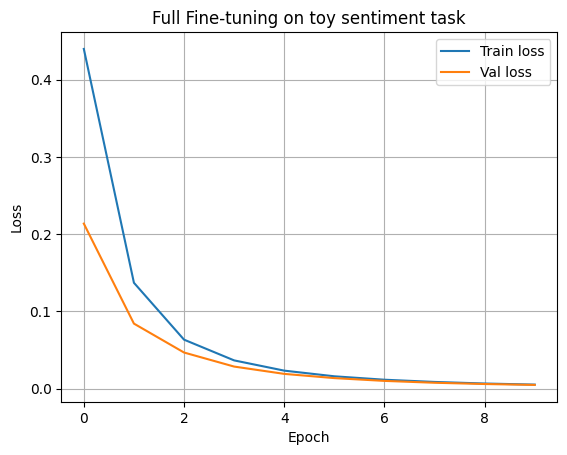

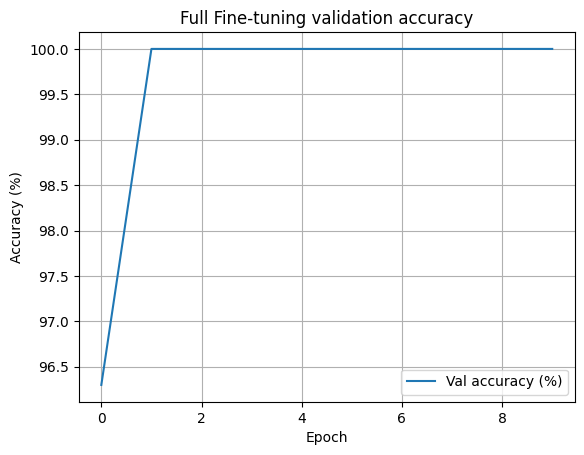

In [7]:
plt.figure()
plt.plot(history_full['train_loss'], label='Train loss')
plt.plot(history_full['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Full Fine-tuning on toy sentiment task')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot([acc*100 for acc in history_full['val_acc']], label='Val accuracy (%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Full Fine-tuning validation accuracy')
plt.legend()
plt.grid(True)
plt.show()


### 3.4 实验 B：软 Prompt Tuning（冻结 Encoder + 可训练 Prompt 向量）


In [8]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

encoder_frozen = SimpleTextEncoder(vocab_size, emb_dim=emb_dim)
encoder_frozen.load_state_dict(encoder_full.state_dict())
for p in encoder_frozen.parameters():
    p.requires_grad = False

class SoftPromptSentiment(nn.Module):
    def __init__(self, frozen_encoder, emb_dim=32, num_prompts=5, num_classes=2):
        super().__init__()
        self.encoder = frozen_encoder
        self.emb_dim = emb_dim
        self.num_prompts = num_prompts
        self.soft_prompts = nn.Parameter(torch.randn(num_prompts, emb_dim) * 0.1)
        self.fc = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        emb = self.encoder.embedding(x)  # (batch, seq_len, emb_dim)
        batch_size = x.size(0)
        prompts = self.soft_prompts.unsqueeze(0).expand(batch_size, -1, -1)
        full_emb = torch.cat([prompts, emb], dim=1)
        mask_tokens = torch.cat([
            torch.ones(batch_size, self.num_prompts, dtype=torch.float32, device=x.device),
            (x != token_to_id['<pad>']).float()
        ], dim=1).unsqueeze(-1)
        masked_emb = full_emb * mask_tokens
        lengths = mask_tokens.sum(dim=1).clamp(min=1.0)
        pooled = masked_emb.sum(dim=1) / lengths
        logits = self.fc(pooled)
        return logits

model_soft = SoftPromptSentiment(encoder_frozen.to(device), emb_dim=emb_dim, num_prompts=5).to(device)

print('Trainable params (Full FT):', count_trainable_params(model_full))
print('Trainable params (Soft prompt):', count_trainable_params(model_soft))


Trainable params (Full FT): 642
Trainable params (Soft prompt): 226


In [9]:
def train_soft_prompt(model, train_loader, val_loader, epochs=10, lr=5e-2):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_samples = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
            total_samples += xb.size(0)
        train_loss = total_loss / total_samples
        val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f'[Soft Prompt] Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%')
    return history

history_soft = train_soft_prompt(model_soft, train_loader, val_loader, epochs=10, lr=5e-2)

loss_fn = nn.CrossEntropyLoss()
test_loss_soft, test_acc_soft = evaluate(model_soft, test_loader, loss_fn, device)
print(f'[Soft Prompt] Test loss={test_loss_soft:.4f}, test_acc={test_acc_soft*100:.2f}%')


[Soft Prompt] Epoch 1: train_loss=0.0941, val_loss=0.0264, val_acc=100.00%
[Soft Prompt] Epoch 2: train_loss=0.0209, val_loss=0.0151, val_acc=100.00%
[Soft Prompt] Epoch 3: train_loss=0.0113, val_loss=0.0092, val_acc=100.00%
[Soft Prompt] Epoch 4: train_loss=0.0077, val_loss=0.0066, val_acc=100.00%
[Soft Prompt] Epoch 5: train_loss=0.0055, val_loss=0.0048, val_acc=100.00%
[Soft Prompt] Epoch 6: train_loss=0.0044, val_loss=0.0038, val_acc=100.00%
[Soft Prompt] Epoch 7: train_loss=0.0034, val_loss=0.0031, val_acc=100.00%
[Soft Prompt] Epoch 8: train_loss=0.0028, val_loss=0.0026, val_acc=100.00%
[Soft Prompt] Epoch 9: train_loss=0.0024, val_loss=0.0023, val_acc=100.00%
[Soft Prompt] Epoch 10: train_loss=0.0020, val_loss=0.0019, val_acc=100.00%
[Soft Prompt] Test loss=0.0020, test_acc=100.00%


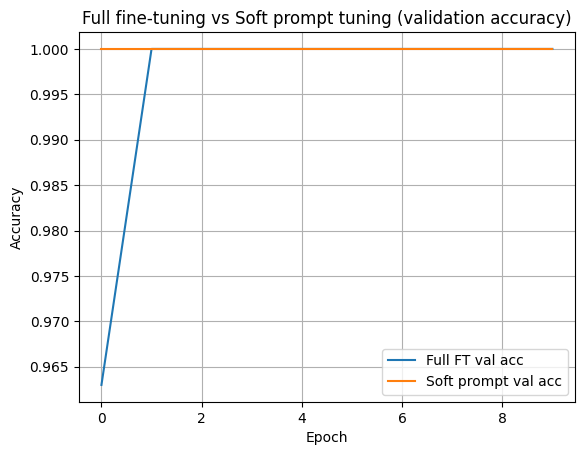

Full FT test acc: 100.00%
Soft Prompt test acc: 100.00%


In [10]:
plt.figure()
plt.plot(history_full['val_acc'], label='Full FT val acc')
plt.plot(history_soft['val_acc'], label='Soft prompt val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Full fine-tuning vs Soft prompt tuning (validation accuracy)')
plt.legend()
plt.grid(True)
plt.show()

print(f'Full FT test acc: {test_acc_full*100:.2f}%')
print(f'Soft Prompt test acc: {test_acc_soft*100:.2f}%')


## 4. Prompting 在 CV 中：视觉 prompt 概念与示例

- 视觉 hard prompt：可解释的视觉元素（点、框、mask、图像对等）；  
- 视觉 soft prompt：像素级 / embedding 级的连续向量（可训练扰动或前缀 token）。  

下面是一个像素级视觉 prompt 的极简结构示意，用于包一层在预训练 CNN 外面（这里只给结构骨架）。


In [11]:
class PixelPromptWrapper(nn.Module):
    # 一个非常简化的像素级视觉 prompt wrapper:
    # - frozen_backbone: 冻结的图像分类网络 (比如预训练 ResNet, ViT)
    # - prompt_patch: 可学习的像素 patch, 叠加到输入图像上
    def __init__(self, frozen_backbone: nn.Module, image_size=(1, 28, 28), prompt_size=(1, 8, 8), alpha=0.1):
        super().__init__()
        self.backbone = frozen_backbone
        for p in self.backbone.parameters():
            p.requires_grad = False

        self.image_size = image_size
        self.prompt_size = prompt_size
        self.alpha = alpha  # 控制扰动强度
        self.prompt_patch = nn.Parameter(torch.zeros(*prompt_size))

    def forward(self, x):
        # x: (batch, C, H, W)
        # 简化做法: 把 prompt_patch 叠加到左上角区域
        B, C, H, W = x.shape
        px, py = self.prompt_size[1], self.prompt_size[2]
        x_perturbed = x.clone()
        x_perturbed[:, :, :px, :py] = x_perturbed[:, :, :px, :py] + self.alpha * self.prompt_patch
        return self.backbone(x_perturbed)

print('PixelPromptWrapper is defined (skeleton). Plug in a frozen CNN backbone in your own environment.')


PixelPromptWrapper is defined (skeleton). Plug in a frozen CNN backbone in your own environment.


## 5. Prompting 在 VLM 中：CLIP、CoOp、CoCoOp、MaPLe 概念

CLIP 通过图文对比学习，学习到图像编码器和文本编码器；下游分类时，把类别名填入文本 prompt 中，再与图像 embedding 做相似度比较即可实现零样本分类。

下面是一个 CoOp 风格的文本 soft prompt 骨架：


In [12]:
class SimpleTextPromptHead(nn.Module):
    # CoOp-style 文本 soft prompt 结构示意:
    # - 假设有一个 frozen_text_encoder, 接受 token embedding 序列并输出句向量
    # - 用可学习上下文向量 + 类别名字拼成 prompt
    def __init__(self, frozen_text_encoder, classnames, ctx_len=4, emb_dim=64):
        super().__init__()
        self.text_encoder = frozen_text_encoder
        for p in self.text_encoder.parameters():
            p.requires_grad = False

        self.classnames = classnames
        self.ctx_len = ctx_len
        self.emb_dim = emb_dim

        self.context = nn.Parameter(torch.randn(ctx_len, emb_dim) * 0.02)
        self.classname_embeddings = nn.Embedding(len(classnames), emb_dim)

    def build_prompts(self):
        # 返回形状 (num_classes, total_len, emb_dim) 的 prompt embedding 序列
        num_classes = len(self.classnames)
        ctx = self.context.unsqueeze(0).expand(num_classes, -1, -1)  # (C, ctx_len, emb_dim)
        class_ids = torch.arange(num_classes)
        cls_emb = self.classname_embeddings(class_ids).unsqueeze(1)  # (C, 1, emb_dim)
        prompts = torch.cat([ctx, cls_emb], dim=1)
        return prompts

    def forward(self):
        prompts = self.build_prompts()
        # 实际使用时: text_features = self.text_encoder(prompts)
        return prompts

print('SimpleTextPromptHead is defined (CoOp-style skeleton). Plug in a real CLIP text encoder in your experiments.')


SimpleTextPromptHead is defined (CoOp-style skeleton). Plug in a real CLIP text encoder in your experiments.


## 6. 总结 & 建议的进一步实验

1. 通过合成情感任务，我们对比了全量微调与软 prompt tuning：后者只更新极少量参数，却仍能取得不错性能。
2. 给出了 ICL / CoT 的 prompt 写法示例，帮助在真实 LLM 环境中直接套用。
3. 在 CV 部分，用 PixelPromptWrapper 展示了像素级 prompt tuning 的基本结构；在 VLM 部分，用 SimpleTextPromptHead 展示了 CoOp 风格文本 prompt 的结构。

你可以在本地进一步：
- 替换 tiny encoder 为 HuggingFace 上的小型 BERT / GPT，做真实的 prompt tuning 实验；  
- 在 CV 任务上加载预训练 ResNet，真正训练 PixelPromptWrapper；  
- 用开源 CLIP + SimpleTextPromptHead 实现 CoOp / CoCoOp / MaPLe 风格的实验。
